# Advanced Demo — PaperSafeStrategy
This notebook fetches data, computes indicators, visualizes signals, and runs backtest metrics.


In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import yfinance as yf
sns.set_theme(style='whitegrid')


In [2]:
# 1) Load BTC data
df = yf.download('BTC-USD', period='2y', interval='1h', auto_adjust=True, progress=False)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [c[0] for c in df.columns]
df = df.rename(columns=str.lower).dropna()
df.head()


,close,high,low,open,volume
Datetime,,,,,
2024-02-13 10:00:00+00:00,49890.804688,50217.500000,49888.492188,50217.500000,0
2024-02-13 11:00:00+00:00,49984.683594,50025.226562,49692.789062,49879.433594,261152768
2024-02-13 12:00:00+00:00,49876.753906,49995.363281,49824.171875,49995.363281,0
2024-02-13 13:00:00+00:00,49600.355469,49939.539062,49254.441406,49876.703125,1677209600
2024-02-13 14:00:00+00:00,48741.460938,49636.917969,48599.031250,49545.531250,2792251392


In [3]:
# 2) Build indicators (similar to strategy)
close=df['close']
df['ema_fast']=close.ewm(span=15, adjust=False).mean()
df['ema_slow']=close.ewm(span=81, adjust=False).mean()
delta=close.diff()
gain=delta.clip(lower=0).rolling(14).mean()
loss=(-delta.clip(upper=0)).rolling(14).mean()
rs=gain/loss
df['rsi']=100-(100/(1+rs))
df['ret']=close.pct_change()
df['vol']=df['ret'].rolling(24).std()
df=df.dropna()
df[['close','ema_fast','ema_slow','rsi','vol']].tail()


,close,ema_fast,ema_slow,rsi,vol
Datetime,,,,,
2026-02-13 05:00:00+00:00,66172.875000,66364.123729,67593.210094,40.256571,0.006516
2026-02-13 06:00:00+00:00,66310.007812,66357.359239,67561.912477,57.195647,0.006538
2026-02-13 07:00:00+00:00,66145.000000,66330.814334,67527.353636,60.034954,0.006532
2026-02-13 08:00:00+00:00,66569.484375,66360.648089,67503.990971,63.116453,0.006686
2026-02-13 09:00:00+00:00,66906.609375,66428.893250,67489.420689,64.413858,0.006623


In [4]:
# 3) Approx signal logic (demo)
long_sig=(df['ema_fast']>df['ema_slow'])&(df['rsi']>65)&(df['vol']>0.003)
short_sig=(df['ema_fast']<df['ema_slow'])&(df['rsi']<35)&(df['vol']>0.003)
df['sig']=0
df.loc[long_sig,'sig']=1
df.loc[short_sig,'sig']=-1
df['sig'].value_counts()


sig
 0    13337
 1     2062
-1     1965
Name: count, dtype: int64

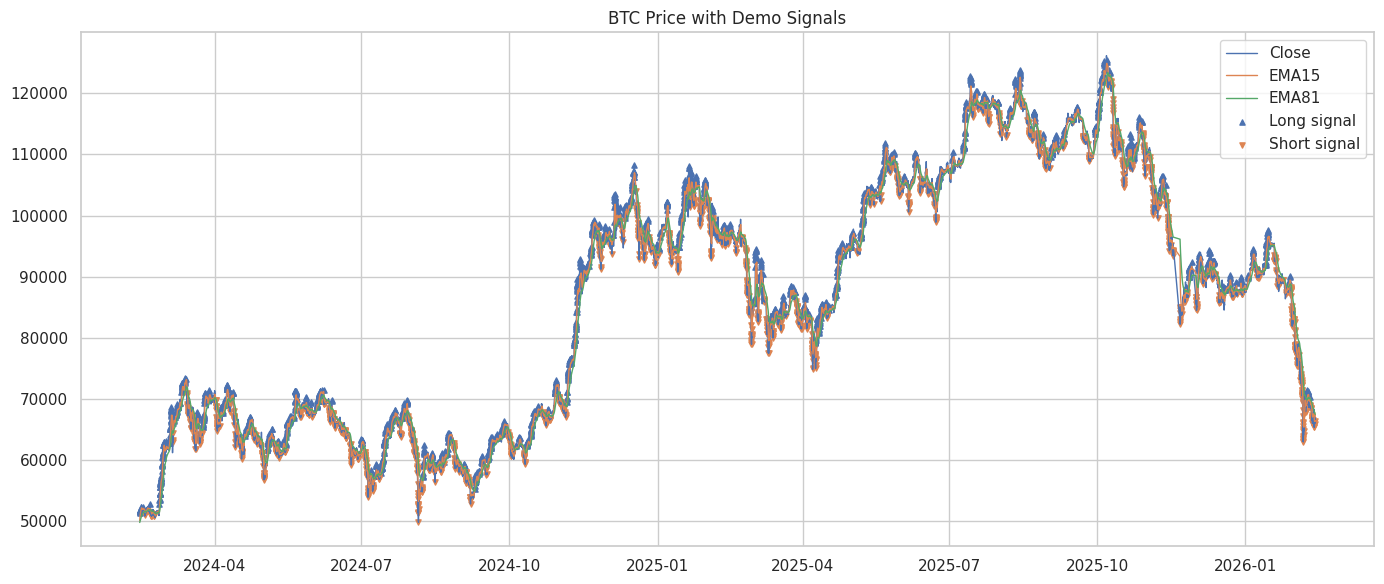

In [5]:
# 4) Price + signals plot
plt.figure(figsize=(14,6))
plt.plot(df.index, df['close'], label='Close', lw=1)
plt.plot(df.index, df['ema_fast'], label='EMA15', lw=1)
plt.plot(df.index, df['ema_slow'], label='EMA81', lw=1)
buy_idx=df.index[df['sig']==1]
sell_idx=df.index[df['sig']==-1]
plt.scatter(buy_idx, df.loc[buy_idx,'close'], s=14, marker='^', label='Long signal')
plt.scatter(sell_idx, df.loc[sell_idx,'close'], s=14, marker='v', label='Short signal')
plt.title('BTC Price with Demo Signals')
plt.legend(); plt.tight_layout(); plt.show()


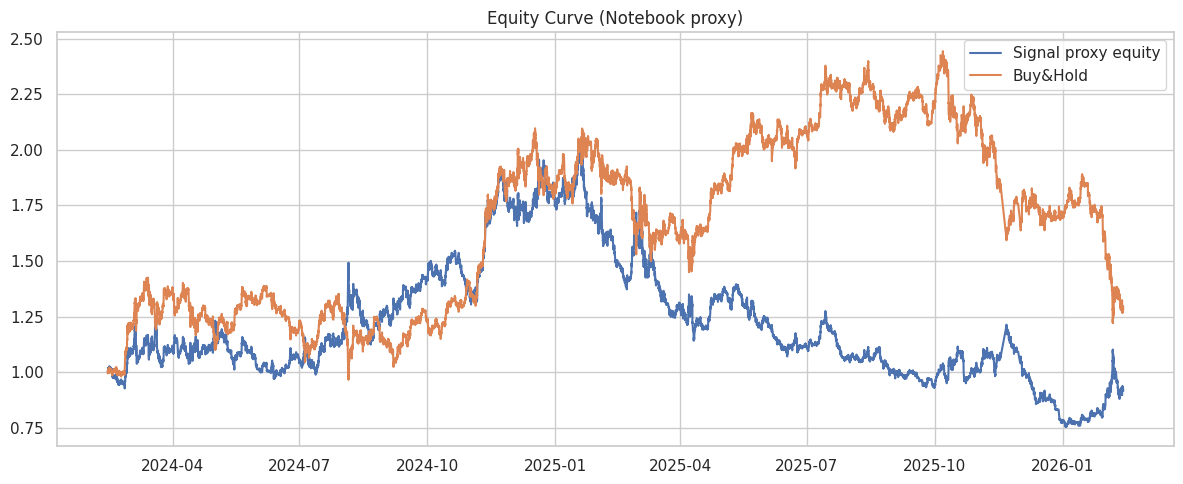

Proxy total return %: -8.51


In [6]:
# 5) Simple PnL proxy (for visualization only)
pos=df['sig'].replace(0,np.nan).ffill().fillna(0)
strat_ret=pos.shift(1)*df['ret']
equity=(1+strat_ret.fillna(0)).cumprod()
buyhold=(1+df['ret'].fillna(0)).cumprod()
plt.figure(figsize=(12,5))
plt.plot(equity.index,equity.values,label='Signal proxy equity')
plt.plot(buyhold.index,buyhold.values,label='Buy&Hold')
plt.title('Equity Curve (Notebook proxy)')
plt.legend(); plt.tight_layout(); plt.show()
print('Proxy total return %:', round((equity.iloc[-1]-1)*100,2))


In [7]:
# 6) Optional: run real freqtrade backtest from notebook
# import subprocess
# cmd = 'freqtrade backtesting --enable-protections --userdir freqtrade --config freqtrade/config.paper.json --strategy PaperSafeStrategy --timerange 20250301-20260201 --timeframe 1h'
# res = subprocess.run(cmd, shell=True, capture_output=True, text=True)
# print(res.stdout[-5000:])


## Notes
- Notebook includes visual diagnostics and a quick proxy equity curve.
- For authoritative metrics, use `freqtrade backtesting` output.
